## Load modules

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '../../../') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0]
Virtual memory usage - total: 126 GB / available: 110 GB / percent used: 12.6 %


## Load model data

In [2]:
# Define period
period = slice('1981','2014')

In [7]:
# Variable
var = 'pr'

if var in ['tas', 'pr']:
    table = 'Amon'

In [8]:
# Load historical
da_historical = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var]

# Load amip
da_amip = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/amip/r1i1p1f1/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var]

# Load land-hist
da_land_hist = xr.open_mfdataset(
    '/bdd/CMIP6/LS3MIP/IPSL/IPSL-CM6A-LR/land-hist/r1i1p1f1/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var]

In [9]:
# Load HighResMIP
da_HR = xr.open_mfdataset(
    '/bdd/CMIP6/HighResMIP/IPSL/IPSL-CM6A-ATM-HR/highresSST-present/r1i1p1f1/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var]
da_HR

<xarray.DataArray 'pr' (time: 408, lat: 361, lon: 512)>
dask.array<getitem, shape=(408, 361, 512), dtype=float32, chunksize=(408, 361, 512), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float32 0.0 0.703125 1.40625 ... 358.59375 359.29688
  * time     (time) datetime64[ns] 1981-01-16T12:00:00 ... 2014-12-16T12:00:00
Attributes:
    long_name:           Precipitation
    units:               kg m-2 s-1
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    standard_name:       precipitation_flux
    description:         at surface; includes both liquid and solid phases fr...
    history:             none
    cell_measures:       area: areacella

## Load obs 
APHRODITE http://aphrodite.st.hirosaki-u.ac.jp/download/data/search/  
http://aphrodite.st.hirosaki-u.ac.jp/download/
V1101 et V1101EX_R1 domain MA

Attention unité mm/day and kg/m2/s for model -> x 86400

In [13]:
obs_V1101 = xr.open_mfdataset(
    '/data/mlalande/APHRODITE/APHRO_MA_050deg_V1101.*.nc', combine='by_coords'
).precip
obs_V1101

<xarray.DataArray 'precip' (time: 9496, latitude: 140, longitude: 180)>
dask.array<concatenate, shape=(9496, 140, 180), dtype=float32, chunksize=(366, 140, 180), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float64 60.25 60.75 61.25 61.75 ... 148.8 149.2 149.8
  * latitude   (latitude) float64 -14.75 -14.25 -13.75 ... 53.75 54.25 54.75
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2006-12-31
Attributes:
    long_name:          daily precipitation analysis interpolated onto 0.5deg...
    units:              mm/day
    level_description:  Earth surface

In [14]:
obs_V1101_EXR1 = xr.open_mfdataset(
    '/data/mlalande/APHRODITE/APHRO_MA_050deg_V1101_EXR1.*.nc', combine='by_coords'
).precip
obs_V1101_EXR1

<xarray.DataArray 'precip' (time: 2922, lat: 140, lon: 180)>
dask.array<concatenate, shape=(2922, 140, 180), dtype=float32, chunksize=(366, 140, 180), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 60.25 60.75 61.25 61.75 ... 148.2 148.8 149.2 149.8
  * lat      (lat) float64 -14.75 -14.25 -13.75 -13.25 ... 53.75 54.25 54.75
  * time     (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2014-12-31
Attributes:
    units:      mm
    long_name:   daily precipitation analysis interpolated onto 0.50deg grids

In [18]:
obs_V1101 = obs_V1101.rename({'longitude': 'lon', 'latitude': 'lat'})

In [21]:
obs = xr.combine_nested([obs_V1101, obs_V1101_EXR1], concat_dim='time')
obs

<xarray.DataArray 'precip' (time: 12418, lat: 140, lon: 180)>
dask.array<concatenate, shape=(12418, 140, 180), dtype=float32, chunksize=(366, 140, 180), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 60.25 60.75 61.25 61.75 ... 148.2 148.8 149.2 149.8
  * lat      (lat) float64 -14.75 -14.25 -13.75 -13.25 ... 53.75 54.25 54.75
  * time     (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2014-12-31

In [31]:
obs = obs.resample(time='1MS').mean('time', skipna='False', keep_attrs=True)
obs

<xarray.DataArray 'precip' (time: 408, lat: 140, lon: 180)>
dask.array<stack, shape=(408, 140, 180), dtype=float32, chunksize=(1, 140, 180), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2014-12-01
  * lon      (lon) float64 60.25 60.75 61.25 61.75 ... 148.2 148.8 149.2 149.8
  * lat      (lat) float64 -14.75 -14.25 -13.75 -13.25 ... 53.75 54.25 54.75

### Regrid using xESMF (https://xesmf.readthedocs.io/en/latest/) 
obs + HR

In [43]:
# For adding NaN values outside of the grid, otherwise it puts 0 (see issue just up #15)
import scipy
def add_matrix_NaNs(regridder):
    X = regridder.weights
    M = scipy.sparse.csr_matrix(X)
    num_nonzeros = np.diff(M.indptr)
    M[num_nonzeros == 0, 0] = np.NaN
    regridder.weights = scipy.sparse.coo_matrix(M)
    return regridder

In [45]:
# Make the regrider
regridder_obs = xe.Regridder(obs, da_historical, 'bilinear', periodic=False)
regridder_obs = add_matrix_NaNs(regridder_obs)
regridder_obs

Overwrite existing file: bilinear_140x180_143x144.nc 
 You can set reuse_weights=True to save computing time.


/home/mlalande/miniconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_140x180_143x144.nc 
Reuse pre-computed weights? False 
Input grid shape:           (140, 180) 
Output grid shape:          (143, 144) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False

In [47]:
# Regrid the data
obs_regrid = regridder_obs(obs)

/home/mlalande/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/mlalande/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


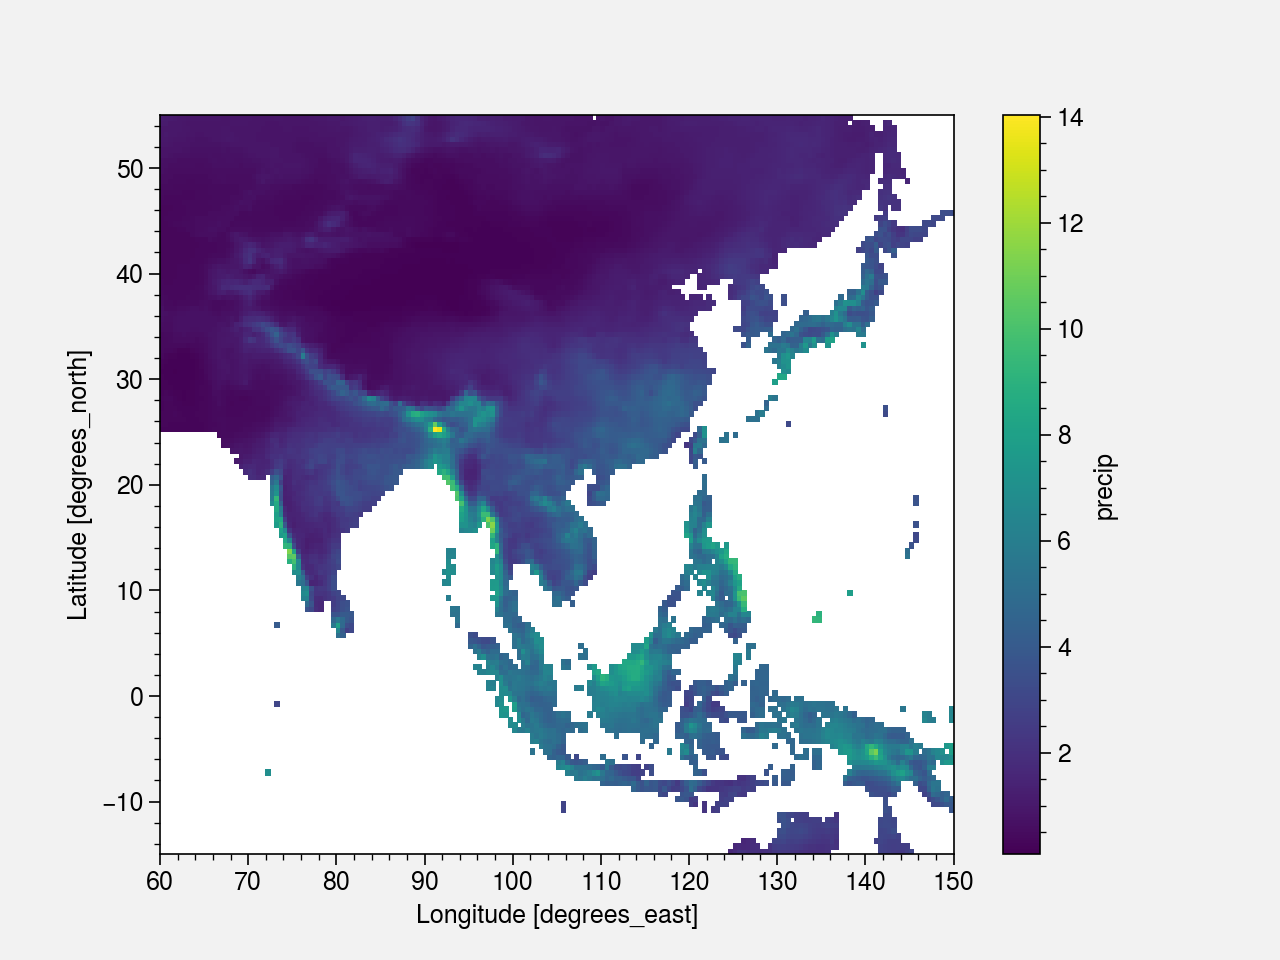

In [39]:
obs.mean('time').plot()

/home/mlalande/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/mlalande/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


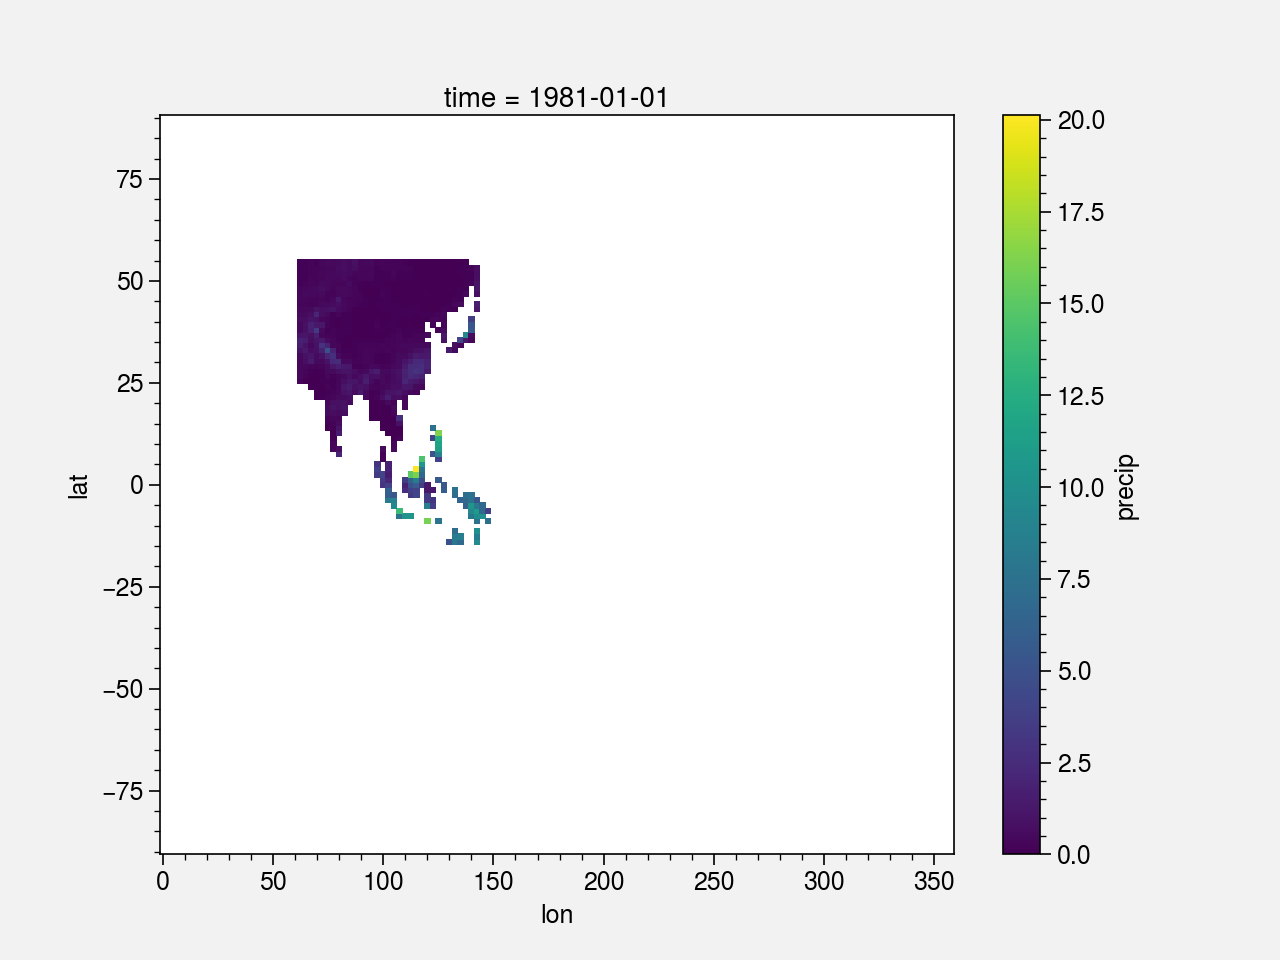

In [48]:
obs_regrid[0].plot()

In [49]:
# Regrid HighResMIP
regridder_HR = xe.Regridder(da_HR, da_historical, 'bilinear', periodic=True)
regridder_HR

Overwrite existing file: bilinear_361x512_143x144_peri.nc 
 You can set reuse_weights=True to save computing time.


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_361x512_143x144_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (361, 512) 
Output grid shape:          (143, 144) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      True

In [50]:
# Regrid the data
da_HR_regrid = regridder_HR(da_HR)

## Annual Climatology

In [51]:
da_historical_clim = u.clim(da_historical)
da_historical_clim.load()

da_amip_clim = u.clim(da_amip)
da_amip_clim.load()

da_land_hist_clim = u.clim(da_land_hist)
da_land_hist_clim.load()

obs_regrid_clim = u.clim(obs_regrid)
obs_regrid_clim.load()

da_HR_regrid_clim = u.clim(da_HR_regrid)
da_HR_regrid_clim.load()

/home/mlalande/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/mlalande/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray (lat: 143, lon: 144)>
array([[1.01048974e-06, 1.01048974e-06, 1.01048974e-06, ...,
        1.01048974e-06, 1.01048974e-06, 1.01048974e-06],
       [2.01212286e-06, 1.77845479e-06, 1.75585594e-06, ...,
        1.88813409e-06, 1.87546862e-06, 1.91167651e-06],
       [1.60559569e-06, 1.53942378e-06, 1.51192191e-06, ...,
        1.61735430e-06, 1.60759005e-06, 1.60895563e-06],
       ...,
       [7.57696721e-06, 7.53386596e-06, 7.54037407e-06, ...,
        7.35905709e-06, 7.39422249e-06, 7.42161540e-06],
       [7.20729306e-06, 7.18925025e-06, 7.21217289e-06, ...,
        7.04875426e-06, 7.06585149e-06, 7.09363609e-06],
       [3.70566805e-06, 3.70566805e-06, 3.70566805e-06, ...,
        3.70566805e-06, 3.70566805e-06, 3.70566805e-06]])
Coordinates:
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float32 -90.0 -88.73239 -87.46479 ... 87.46479 88.73239 90.0
Attributes:
    regrid_method:  bilinear

In [53]:
concat = xr.combine_nested(
    [
        (da_historical_clim*86400)-obs_regrid_clim,
        (da_amip_clim*86400)-obs_regrid_clim,
        (da_land_hist_clim*86400)-obs_regrid_clim,
        (da_HR_regrid_clim*86400)-obs_regrid_clim
    ],
    concat_dim='diff'
)

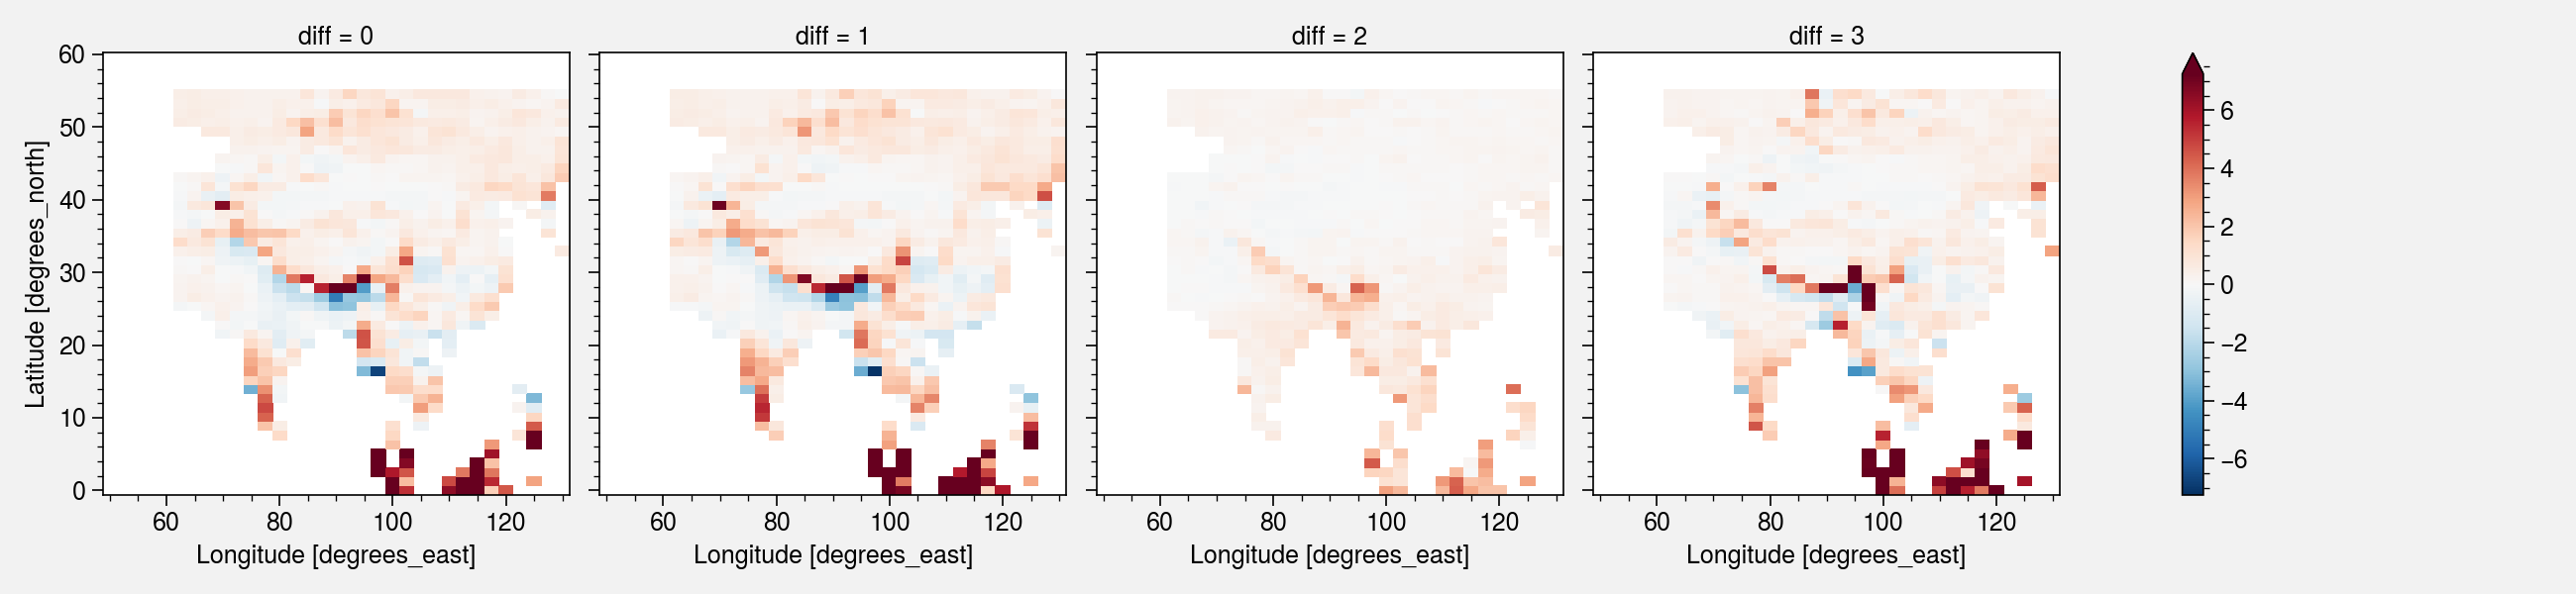

In [63]:
concat.sel(lat=slice(0,60), lon=slice(50,130)).plot(col='diff', robust=True)

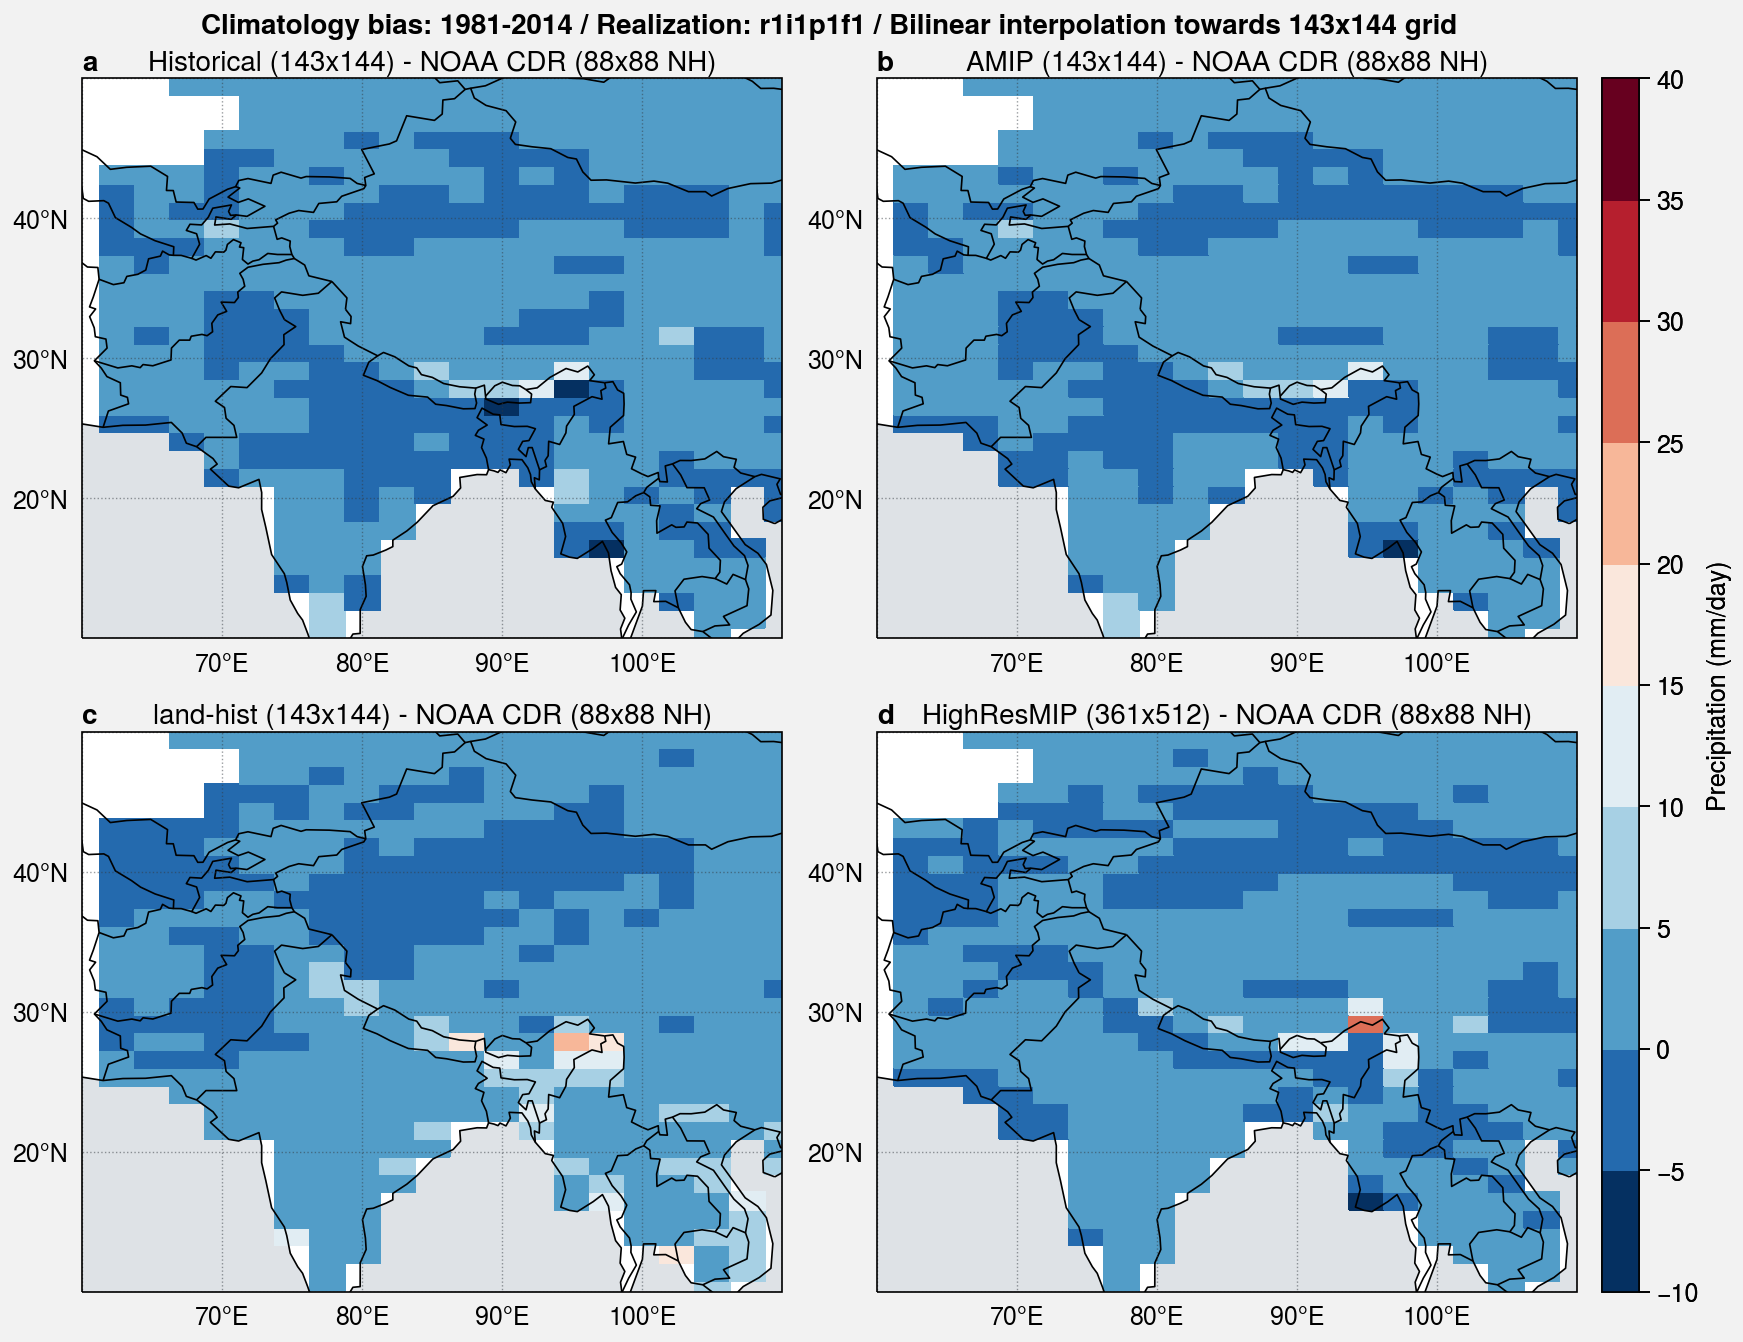

In [61]:
# Differences from Rutger
f, axs = plot.subplots(proj='cyl', ncols=2, nrows=2, share=3, axwidth=3.5)

cmap='RdBu_r'
levels=plot.arange(-20,10,2)

m = axs[0].pcolormesh((da_historical_clim*86400)-obs_regrid_clim, cmap=cmap, 
#                       levels=levels, 
#                       extend='both',
#                       norm='midpoint'
                     )
axs[0].format(title='Historical (143x144) - NOAA CDR (88x88 NH)')
m = axs[1].pcolormesh((da_amip_clim*86400)-obs_regrid_clim, cmap=cmap, 
#                   levels=levels, 
#                   extend='both',
#                   norm='midpoint'
                 )
axs[1].format(title='AMIP (143x144) - NOAA CDR (88x88 NH)')
axs[2].pcolormesh((da_land_hist_clim*86400)-obs_regrid_clim, cmap=cmap, 
#                   levels=levels, 
#                   extend='both',
#                   norm='midpoint'
                 )
axs[2].format(title='land-hist (143x144) - NOAA CDR (88x88 NH)')
axs[3].pcolormesh((da_HR_regrid_clim*86400)-obs_regrid_clim, cmap=cmap, 
#                   levels=levels, 
#                   extend='both',
#                   norm='midpoint'
                 )
axs[3].format(title='HighResMIP (361x512) - NOAA CDR (88x88 NH)')

f.colorbar(m, label='Precipitation (mm/day)')

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle="Climatology bias: 1981-2014 / Realization: r1i1p1f1 / Bilinear interpolation towards 143x144 grid",
    lonlines=10, latlines=10, abc=True, latlim=(10,50), lonlim=(60,110)
)

# f.save('bias_hist_amip_land.png')